参考：
- http://aidiary.hatenablog.com/entry/20180304/1520172429
- https://github.com/cross32768/VGAN/blob/master/VGAN.ipynb

In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from tensorboardX import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [4]:
def train(D, G, D_criterion, G_criterion, D_optimizer, G_optimizer, data_loader, beta, writer, num_iter):

    # 本物のラベルは1
    y_real = torch.ones(batch_size, 1)
    # 偽物のラベルは0
    y_fake = torch.zeros(batch_size, 1)
    
    y_real = y_real.to(device)
    y_fake = y_fake.to(device)

    D_running_loss = 0
    G_running_loss = 0
    
    for batch_idx, (real_images, _) in enumerate(tqdm(data_loader)):
        # 訓練モードへ
        D.train()
        G.train()
        
        z = torch.rand((batch_size, z_dim))
        real_images, z = real_images.to(device), z.to(device)

        # Discriminatorの更新
        D_optimizer.zero_grad()

        # Discriminatorにとって本物画像の認識結果は1（本物）に近いほどよい
        # E[log(D(x))]
        D_real, mean, logvar = D(real_images)
        D_real_loss, loss_kldiv_real = D_criterion(D_real, y_real, mean, logvar, beta)

        # DiscriminatorにとってGeneratorが生成した偽物画像の認識結果は0（偽物）に近いほどよい
        # E[log(1 - D(G(z)))]
        # fake_imagesを通じて勾配がGに伝わらないようにdetach()して止める
        fake_images = G(z)
        D_fake, mean, logvar = D(fake_images.detach()) # ここはdetachする。
        D_fake_loss, loss_kldiv_fake = D_criterion(D_fake, y_fake, mean, logvar, beta)

        # 2つのlossの和を最小化する
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()

        # -------------------------------- ここから
        loss_kldiv = loss_kldiv_real.item() + loss_kldiv_fake.item()
        beta = max(0.0, beta + alpha * loss_kldiv)
        # -------------------------------- ここまで
        
        # Generatorの更新
        z = torch.rand((batch_size, z_dim))
        z = z.to(device)

        G_optimizer.zero_grad()

        fake_images = G(z)
        D_fake, mean, logvar = D(fake_images) # Dに判別してもらう！
        G_loss = G_criterion(D_fake, y_real) # 本物が多いとloss小。
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
        
        # TensorBoardX
        writer.add_scalar('train_G_loss', G_loss.item(), num_iter)
        writer.add_scalar('train_D_loss', D_loss.item(), num_iter)
        writer.add_scalar('beta', beta, num_iter)
        if num_iter % 50 == 0:
            G.eval()
            sample_z = torch.rand((64, z_dim)).to(device)
            with torch.no_grad():
                sample = G(sample_z).to('cpu')
            writer.add_image('Image_from_latent', make_grid(sample, nrow=8, padding=1), num_iter)
        num_iter += 1
    
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss, num_iter, beta

In [5]:
def generate(epoch, G, log_dir='logs'):
    G.eval()
    
    os.makedirs(log_dir, exist_ok=True)

    sample_z = torch.rand((64, z_dim))
    sample_z = sample_z.to(device)
    
    with torch.no_grad():
        samples = G(sample_z).to('cpu')
    save_image(samples, os.path.join(log_dir, 'epoch_%03d.png' % (epoch)))

In [6]:
# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 62
num_epochs = 100
sample_num = 16
log_dir = './logs/vgan'

In [7]:
# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.MNIST('data/mnist', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

(-0.5, 145.5, 145.5, -0.5)

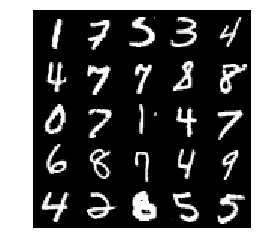

In [8]:
# データの可視化
def imshow(img):
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(data_loader).next()
images, labels = images[:25], labels[:25]
imshow(make_grid(images, nrow=5, padding=1))
plt.axis('off')

In [9]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # 1x28x28
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), # -> 64x32x32
#             nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> 128x16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        # -------------------------------- ここから
        self.conv_mus = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0) # -> 128x7x7
        self.conv_sigmas = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0) # -> 128x7x7
        # -------------------------------- ここまで
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.conv(input)
        
        # -------------------------------- ここから
        mus = self.conv_mus(x).view(-1, 128 * 7 * 7) # mean
        sigmas = self.conv_sigmas(x).view(-1, 128 * 7 * 7) # logvar
        sigmas = F.sigmoid(sigmas)
        
        noise = torch.randn(mus.size(), device=device)
        z = noise * sigmas + mus
#         z = (0.5 * sigmas).exp() * noise + mus
        # -------------------------------- ここまで
        
        x = self.fc(z)
        return x, mus, sigmas
#         x = x.view(-1, 128 * 7 * 7) 
#         x = self.fc(x)
#         return x, 0, 0

In [10]:
# initialize network
G = Generator().to(device)
D = Discriminator().to(device)

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# -------------------------------- ここから
I_c = 0.1
beta = 1.0
alpha = 1e-5

# def VDB_loss(out, label, mus, sigmas, beta):
def VDB_loss(out, label, mean, sigma, beta):
    normal_D_loss = F.binary_cross_entropy(out, label)
    
#     kldiv_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
#     kldiv_loss = 0.5 * torch.sum(logvar.exp() + mean.pow(2) - logvar - 1)
    kldiv_loss = 0.5 * torch.mean(mean.pow(2) + sigma.pow(2) - (sigma.pow(2)+1e-8).log() - 1)
    kldiv_loss = kldiv_loss.mean() - I_c
    kldiv_loss = kldiv_loss - I_c
#     print(kldiv_loss, normal_D_loss)
    final_loss = normal_D_loss + beta * kldiv_loss
    
    return final_loss, kldiv_loss.detach()
#     return F.binary_cross_entropy(out, label), 0
# -------------------------------- ここまで

G_criterion = nn.BCELoss()
D_criterion = VDB_loss

In [11]:
# D = Discriminator().to(device)
# input = torch.rand((32, 3, 64, 64)).to(device)
# out, mean, logvar = D(input)
# # print(out.size(), mean.size(), logvar.size())

In [ ]:
writer = SummaryWriter()

history = {}
history['D_loss'] = []
history['G_loss'] = []
num_iter = 0

for epoch in range(num_epochs):
    D_loss, G_loss, num_iter, beta = train(D, G, D_criterion, G_criterion, D_optimizer, G_optimizer, data_loader, beta, writer, num_iter)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # Generatorから画像を生成してモデルも保存
    generate(epoch + 1, G, log_dir)
    torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
    torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

  0%|          | 0/468 [00:00<?, ?it/s]/home/nama/.pyenv/versions/3.6.5/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|          | 2/468 [00:00<00:23, 19.66it/s]

epoch 1, D_loss: 1.1852 G_loss: 0.6943


  0%|          | 2/468 [00:00<00:23, 19.85it/s]

epoch 2, D_loss: 1.0018 G_loss: 0.6935


  0%|          | 2/468 [00:00<00:23, 19.66it/s]

epoch 3, D_loss: 0.9923 G_loss: 0.6934


  0%|          | 2/468 [00:00<00:23, 19.61it/s]

epoch 4, D_loss: 0.9907 G_loss: 0.6933


  1%|          | 3/468 [00:00<00:22, 20.52it/s]

epoch 5, D_loss: 0.9905 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:23, 19.70it/s]

epoch 6, D_loss: 0.9908 G_loss: 0.6933


  1%|          | 3/468 [00:00<00:22, 20.42it/s]

epoch 7, D_loss: 0.9913 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:23, 19.82it/s]

epoch 8, D_loss: 0.9919 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.58it/s]

epoch 9, D_loss: 0.9926 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.49it/s]

epoch 10, D_loss: 0.9933 G_loss: 0.6932


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 11, D_loss: 0.9940 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:23, 19.73it/s]

epoch 12, D_loss: 0.9947 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.58it/s]

epoch 13, D_loss: 0.9955 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.57it/s]

epoch 14, D_loss: 0.9962 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:23, 19.87it/s]

epoch 15, D_loss: 0.9969 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:23, 19.86it/s]

epoch 16, D_loss: 0.9977 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.56it/s]

epoch 17, D_loss: 0.9984 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:24, 19.31it/s]

epoch 18, D_loss: 0.9991 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:23, 19.88it/s]

epoch 19, D_loss: 0.9999 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.54it/s]

epoch 20, D_loss: 1.0006 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.42it/s]

epoch 21, D_loss: 1.0014 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.41it/s]

epoch 22, D_loss: 1.0021 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.38it/s]

epoch 23, D_loss: 1.0029 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:23, 19.55it/s]

epoch 24, D_loss: 1.0036 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:28, 16.13it/s]

epoch 25, D_loss: 1.0044 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.61it/s]

epoch 26, D_loss: 1.0051 G_loss: 0.6932


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 27, D_loss: 1.0059 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.47it/s]

epoch 28, D_loss: 1.0066 G_loss: 0.6932


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 29, D_loss: 1.0073 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:24, 19.03it/s]

epoch 30, D_loss: 1.0081 G_loss: 0.6933


  1%|          | 3/468 [00:00<00:22, 20.48it/s]

epoch 31, D_loss: 1.0088 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.52it/s]

epoch 32, D_loss: 1.0096 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.38it/s]

epoch 33, D_loss: 1.0103 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.69it/s]

epoch 34, D_loss: 1.0111 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:24, 19.09it/s]

epoch 35, D_loss: 1.0118 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:23, 19.99it/s]

epoch 36, D_loss: 1.0126 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.30it/s]

epoch 37, D_loss: 1.0133 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.48it/s]

epoch 38, D_loss: 1.0141 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.47it/s]

epoch 39, D_loss: 1.0148 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.55it/s]

epoch 40, D_loss: 1.0156 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:23, 19.82it/s]

epoch 41, D_loss: 1.0163 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.54it/s]

epoch 42, D_loss: 1.0171 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.54it/s]

epoch 43, D_loss: 1.0178 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:23, 19.93it/s]

epoch 44, D_loss: 1.0186 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.48it/s]

epoch 45, D_loss: 1.0193 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.62it/s]

epoch 46, D_loss: 1.0201 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.55it/s]

epoch 47, D_loss: 1.0208 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.49it/s]

epoch 48, D_loss: 1.0216 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.27it/s]

epoch 49, D_loss: 1.0223 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:28, 16.28it/s]

epoch 50, D_loss: 1.0231 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.42it/s]

epoch 51, D_loss: 1.0238 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.43it/s]

epoch 52, D_loss: 1.0245 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.55it/s]

epoch 53, D_loss: 1.0253 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.24it/s]

epoch 54, D_loss: 1.0260 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.59it/s]

epoch 55, D_loss: 1.0268 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:23, 19.91it/s]

epoch 56, D_loss: 1.0275 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.48it/s]

epoch 57, D_loss: 1.0283 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.52it/s]

epoch 58, D_loss: 1.0290 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.52it/s]

epoch 59, D_loss: 1.0298 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.57it/s]

epoch 60, D_loss: 1.0305 G_loss: 0.6932


  0%|          | 0/468 [00:00<?, ?it/s]

epoch 61, D_loss: 1.0313 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:23, 19.56it/s]

epoch 62, D_loss: 1.0320 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.49it/s]

epoch 63, D_loss: 1.0328 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.61it/s]

epoch 64, D_loss: 1.0335 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:23, 19.76it/s]

epoch 65, D_loss: 1.0343 G_loss: 0.6932


  1%|          | 3/468 [00:00<00:22, 20.31it/s]

epoch 66, D_loss: 1.0350 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:23, 19.72it/s]

epoch 67, D_loss: 1.0358 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:23, 19.90it/s]

epoch 68, D_loss: 1.0365 G_loss: 0.6932


  0%|          | 2/468 [00:00<00:24, 19.37it/s]

epoch 69, D_loss: 1.0373 G_loss: 0.6932


 59%|█████▉    | 278/468 [00:13<00:09, 19.89it/s]

In [ ]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [ ]:
from IPython.display import Image
Image('logs/vgan/epoch_001.png')

In [ ]:
Image('logs/vgan/epoch_010.png')